## Secant method

__MATH 420__ <br>
_Spring 2021_ <br>
Section 2.4 <br>


Here is simple code for the secant method. We default the tolerance `tol` to $64$ times the machine epsilon of the initial guess $x_0$ and the maximum number of iterations `maxiter` to 1000. Both `tol` and `maxiter` are keyword arguments.

We'll stop when $f(x_k)$ is sufficiently small.  For ``small,'' we'll use `isapprox(f1,0, atol = tol, rtol=0)`, where `tol` is user settable.

The secant method requires two initial guesses for the zero. As a convenience to the user, we will default the second initial guess to $x_0 + f(x_0)$, where $x_0$ is the first guess. There isn't much mathematical logic behind this choice, but when $f(x_0)$ is small (and presumably $x_0$ is close to the true zero), we have $x_1$ close to $x_0$. It seems reasonable to choose $x_1$ close to $x_0$ when $f(x_0)$ is small.

Each time through the loop, we compute only one new value for the function.

We'll define a custom exception for apparent nonconvergence.

In [1]:
struct NoConvergenceError <: Exception
    message::String
    iterations::Int
end

function Base.showerror(io::IO, e::NoConvergenceError)
    println(io, e.message)
    println(io, "Number of iterations: ", e.iterations)
end

In [2]:
function secant_method(f::Function,x0::Number,x1::Number = x0 + f(x0),
    tol = 64*eps(typeof(x0)), maxiter::Integer = 1000)
    f0 = f(x0)
    f1 = f(x1) 
    iter = 0
    while !isapprox(f1,0.0, atol = tol, rtol=0) && !isnan(x1) && maxiter > iter # early stop when x1 = NaN
        iter += 1
        xx = x1 - f1 * (x1 - x0) / (f1 - f0) 
        (x0,x1,f0,f1) = (x1,xx,f1,f(xx)) 
    end    
    # error when too many iterations; otherwise, return the midpoint of x0 & x1
    if iter == maxiter
        throw(NoConvergenceError("secant_method: Exceeded maximum number of iterations.", iter))
    else
        (x0+x1)/2
    end
end;

Let's look for zeros of the function $x \mapsto x \exp(x) - 107$.  First, a graphical study.

In [3]:
F = x -> x*exp(x) - 107

#9 (generic function with 1 method)

In [4]:
using Gadfly

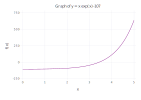

In [5]:
plot(F,0,5,color=[colorant"purple"],Guide.title("Graph of y = x exp(x)-107"))

There is a zero between $3$ and $4$. Let's try several values for the two initial values of the secant sequence.

In [6]:
 secant_method(F, 0.0, 3.0)

3.437952688840655

In [7]:
 secant_method(F, -1.5, 2.0)

3.437952688840652

We might like to save the terms of the sequence and plot them.  No problem-we'll write a specialized version of the secant method that does this

In [8]:
function secant_sequence(f::Function,x0::Number,x1::Number = x0 + f(x0), tol = 64*eps(typeof(x0)), maxiter::Integer = 1000)
    f0 = f(x0)
    f1 = f(x1) 
    iter = 0
    pts = []
    push!(pts, x0)
    push!(pts, x1)
    while !isapprox(f1,0.0, atol = tol, rtol=0) && !isnan(x1) && maxiter > iter # early stop when x1 = NaN
        iter += 1
        xx = x1 - f1 * (x1 - x0) / (f1 - f0) 
        (x0,x1,f0,f1) = (x1,xx,f1,f(xx)) 
        push!(pts,x1)
    end    
    # error when too many iterations; otherwise, return the midpoint
    if iter == maxiter
        throw(NoConvergenceError("secant_method: Exceeded maximum number of iterations.", iter))
    else
        pts
    end
end;

In [9]:
xx = secant_sequence(F, 2.0, 18.0);

In [10]:
n = length(xx)

19

To plot the sequence, construct an array of the inputs

In [11]:
xpts = [k for k = 1 : n];

The graph wobbles a bit, then approaches its asymptote fairly quickly:

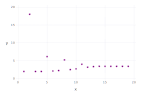

In [12]:
plot(x=xpts, y=xx,color=[colorant"purple"])

Let us determine if $E(k+2) = q E(k) E(k+1)$ is approximately correct for large k, where $q = f^{\prime\prime} (z) /(2 f'(z))$ and $z$ is zero the zero of $f$. For our case $z \approx  3.437952688840655$

In [13]:
xf = last(xx)

3.437952688840655

In [14]:
e = [xx[k] - xf for k = 1 : n];

In [15]:
ee = [e[k+2]/(e[k] * e[k+1]) for k = 1 : n-2];

The value of $E(k+2) / E(k) E(k+1)$ seems to approach a number that is close to  $0.6$. The last value in the array ee is $0.0$. This doesn't mean that the sequence converges to zero, but rather it means that the value of $E_{k+2}$ underflows to zero before $E_{k}
  E_{k+1}$ underflows to zero.

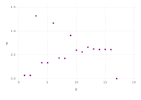

In [16]:
plot(x=xpts[1:n-2], y=ee,color=[colorant"purple"])

Let's check the value of $f^{\prime\prime} (z) /(2 f^\prime (z))$ where $z = 3.437952688840655 $. We could do this calculation by hand, but computing derivatives is easy using Julia's `ForwardDiff` package.

In [17]:
using ForwardDiff

In [18]:
dF = x -> ForwardDiff.derivative(F, x)

#15 (generic function with 1 method)

In [19]:
ddF = x -> ForwardDiff.derivative(dF, x)

#17 (generic function with 1 method)

Graphically, we estimated a limit of about $0.6$.  This agrees with the theoretical value:

In [20]:
(ddF(xf)/(2 * dF(xf)))

0.6126645629317462

Looking at the values of the array `ee,` the values match the theoretical value fairly well.

Bigfloat inputs are no problem-the same code works for `BigFloat` numbers. Here is a 
where the default stopping condition doesn't stop the iteration soon enough. 


In [21]:
secant_method(F, BigFloat(3.0), BigFloat(4.0))

NaN

In [22]:
secant_method(F, BigFloat(3.0), BigFloat(4.0),BigFloat(1.0e-70), 100)

3.437952688840654822321974795488057388738807628765291842552187018015167708552399

A tricky case: The true zero is 2, but the function of is very close to 0 in a largish neighborhood of 2.

In [23]:
G = x -> (x-2)^42

#19 (generic function with 1 method)

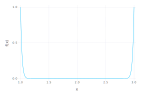

In [24]:
plot(G,1,3)

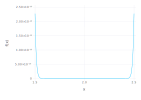

In [25]:
plot(G,1.5,2.5)

With the default value of the tolerance, and using initial values of 1.5 and 2.2, we get immediate convergence

In [26]:
xxx = secant_method(G, 1.5, 2.2)

1.85

Sure, we can reduce the tolerance, but we can get division by zero errors

In [27]:
xxx = secant_method(G, 1.5, 2.5, 1.0e-13)

NaN

This works, more-or-less, but even with a tolerance of $10^{-100}$ we get a value for the zero that differs from the true value by about $0.005$

In [28]:
xxx = secant_method(G, 1.5, 3.0, 1.0e-100)

1.9958475476400617

What's the story? For the function $F = x \mapsto (x-2)^{42}$, we have  $F(2) = 0 $ and $F^\prime(2) = 0$. Because of this, we say that $2$ is a _degenerate zero_ of $F$. Our result that $E(k+2) = q E(k) E(k+1)$ is approximately correct for large $k$ makes the assumption that the zero isn't degenerate.
